In [54]:
# Main libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelEncoder, StandardScaler

# Scikit-learn: Models
from sklearn.ensemble import (
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    RandomForestClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    accuracy_score, 
    auc, 
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from matplotlib.colors import LogNorm



In [ ]:
df = pd.read_csv('dataset/flights.csv')

In [6]:
df = ETL(df)

In [7]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'ACT_TO_CRS_RATIO', 'FL_MON', 'FL_DAY', 'FL_YEAR', 'FL_DOW',
       'C_REASON'],
      dtype='object')

# ETL for classification

In [8]:
def categorize_delay(row):
    arr_delay = row['ARR_DELAY']
    cancelled = row['CANCELLED']
    diverted = row['DIVERTED']
    
    if cancelled == 1:
        return 6  # Volo cancellato
    
    if diverted == 1:
        return 5  # Volo deviato
    
    if arr_delay < -5:
        return 0  # Volo in anticipo
    
    if -5 <= arr_delay <= 5:
        return 1  # Volo puntuale
    
    if 5 < arr_delay <= 15:
        return 2  # Ritardo breve
    
    if 15 < arr_delay <= 60:
        return 3  # Ritardo medio
    
    if arr_delay > 60:
        return 4  # Ritardo lungo
    
    return 7  # Caso non definito (eventuali dati mancanti o errati)

df['FLIGHT_STATUS'] = df.apply(categorize_delay, axis=1)

In [9]:
df['FLIGHT_STATUS'].value_counts()

FLIGHT_STATUS
0    55227
1    28762
3    14702
2    11966
4     6420
6     1902
5      292
Name: count, dtype: int64

In [10]:
def parse_time_column(column):
    """Estrae ore e minuti da una colonna di orari."""
    times = pd.to_numeric(column, errors='coerce').fillna(0).astype(int).astype(str).str.zfill(4)
    return times.str[:2].astype(int), times.str[2:].astype(int)

def process_time_columns(df, time_columns):
    """Estrae ore e minuti per le colonne temporali e rimuove le colonne originali."""
    for col in time_columns:
        hours, minutes = parse_time_column(df[col])
        df[f'{col}_HOUR'], df[f'{col}_MIN'] = hours, minutes
        df.drop(columns=[col], inplace=True)  # Rimuove la colonna originale
    return df

# Funzione per ottenere il numero di giorni in un mese
def days_in_month(month, year):
    # Usa un calendario per determinare il numero di giorni nel mese
    if month == 2:
        # Se è febbraio, considera l'anno bisestile
        return 29 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 28
    elif month in [4, 6, 9, 11]:
        return 30  # Aprile, Giugno, Settembre, Novembre
    else:
        return 31  # Gennaio, Marzo, Maggio, Luglio, Agosto, Ottobre, Dicembre

# Funzione per encoding ciclico delle variabili temporali
def encode_cyclic_features(df, feature, max_val):
    df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / max_val)
    df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / max_val)
    return df

# Funzione per encoding ciclico specifico per FL_DAY con il numero effettivo di giorni nel mese
def encode_cyclic_day_features(df):
    # Calcolare il numero di giorni per ogni mese e anno
    df['days_in_month'] = df.apply(lambda row: days_in_month(row['FL_MON'], row['FL_YEAR']), axis=1)
    
    # Creare la codifica ciclica per FL_DAY
    df['FL_DAY_sin'] = np.sin(2 * np.pi * df['FL_DAY'] / df['days_in_month'])
    df['FL_DAY_cos'] = np.cos(2 * np.pi * df['FL_DAY'] / df['days_in_month'])
    
    # Rimuovere la colonna intermedia 'days_in_month'
    df = df.drop(columns=['days_in_month', 'FL_DAY'])
    
    return df

## Normalizzazzione

In [11]:
# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 
    'ACT_TO_CRS_RATIO', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
    'AIR_TIME', 'DISTANCE'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = min_max_scaler.fit_transform(df[standard_features])

In [12]:
# QUESTA PARTE NON è NECESSARIA

# Colonne di partenza per le trasformazioni temporali
'''base_time_columns = ['DEP_TIME', 'ARR_TIME','WHEELS_OFF', 'WHEELS_ON']

# Chiamata al metodo che processa queste colonne
df = process_time_columns(df, base_time_columns)

# Aggiungere suffissi _HOUR e _MIN alle colonne di partenza
time_features = ['FL_MON', 'FL_DOW'] + [f"{col}_{suffix}" for col in base_time_columns for suffix in ['HOUR', 'MIN']]

# Creare il feature map in modo dinamico
feature_map = {f"{col}_HOUR": 24 for col in base_time_columns}
feature_map.update({f"{col}_MIN": 60 for col in base_time_columns})
feature_map.update({'FL_MON': 12, 'FL_DOW': 7})

# Trasformazioni cicliche per le variabili temporali
for feature, max_val in feature_map.items():
    if feature in df.columns:
        df = encode_cyclic_features(df, feature, max_val)

# Applicare l'encoding ciclico specifico per FL_DAY
df = encode_cyclic_day_features(df)

# Creare il MinMaxScaler per FL_YEAR
scaler = MinMaxScaler()

# Applicare la normalizzazione e mantenere il formato DataFrame
df[['FL_YEAR']] = scaler.fit_transform(df[['FL_YEAR']])

# Rimozione delle colonne temporali originali (opzionale)
df = df.drop(columns=time_features, errors='ignore')'''

'base_time_columns = [\'DEP_TIME\', \'ARR_TIME\',\'WHEELS_OFF\', \'WHEELS_ON\']\n\n# Chiamata al metodo che processa queste colonne\ndf = process_time_columns(df, base_time_columns)\n\n# Aggiungere suffissi _HOUR e _MIN alle colonne di partenza\ntime_features = [\'FL_MON\', \'FL_DOW\'] + [f"{col}_{suffix}" for col in base_time_columns for suffix in [\'HOUR\', \'MIN\']]\n\n# Creare il feature map in modo dinamico\nfeature_map = {f"{col}_HOUR": 24 for col in base_time_columns}\nfeature_map.update({f"{col}_MIN": 60 for col in base_time_columns})\nfeature_map.update({\'FL_MON\': 12, \'FL_DOW\': 7})\n\n# Trasformazioni cicliche per le variabili temporali\nfor feature, max_val in feature_map.items():\n    if feature in df.columns:\n        df = encode_cyclic_features(df, feature, max_val)\n\n# Applicare l\'encoding ciclico specifico per FL_DAY\ndf = encode_cyclic_day_features(df)\n\n# Creare il MinMaxScaler per FL_YEAR\nscaler = MinMaxScaler()\n\n# Applicare la normalizzazione e mantenere il

In [13]:
drop_features = [
    'CRS_DEP_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_DEP_TIME', 'ARR_DELAY', 
    'CANCELLED', 'DIVERTED', 'FL_YEAR', 

    'DEP_TIME', 'ARR_TIME','WHEELS_OFF', 'WHEELS_ON',
    'ORIGIN', 'DEST', 'OP_CARRIER',
    'FL_MON',	'FL_DAY',	'FL_DOW'
]

df = df.drop(columns=drop_features, errors='ignore')

In [14]:
# Create dummies - for better model outcomes
df = pd.get_dummies(df)

In [15]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,ACT_TO_CRS_RATIO,FLIGHT_STATUS,C_REASON_Airline/Carrier,C_REASON_National Air System,C_REASON_Not cancelled,C_REASON_Security,C_REASON_Weather
0,0.120859,0.026432,0.008658,0.097331,0.101979,0.093651,0.067447,0.160497,0,False,False,True,False,False
1,0.127607,0.057269,0.021645,0.054945,0.070015,0.044444,0.020800,0.166327,1,False,False,True,False,False
2,0.119632,0.088106,0.017316,0.356358,0.385084,0.363492,0.331785,0.197895,1,False,False,True,False,False
3,0.123313,0.057269,0.017316,0.318681,0.310502,0.296825,0.265751,0.176896,0,False,False,True,False,False
4,0.120245,0.044053,0.030303,0.185243,0.197869,0.179365,0.155695,0.183183,0,False,False,True,False,False


# Correlation Analysis

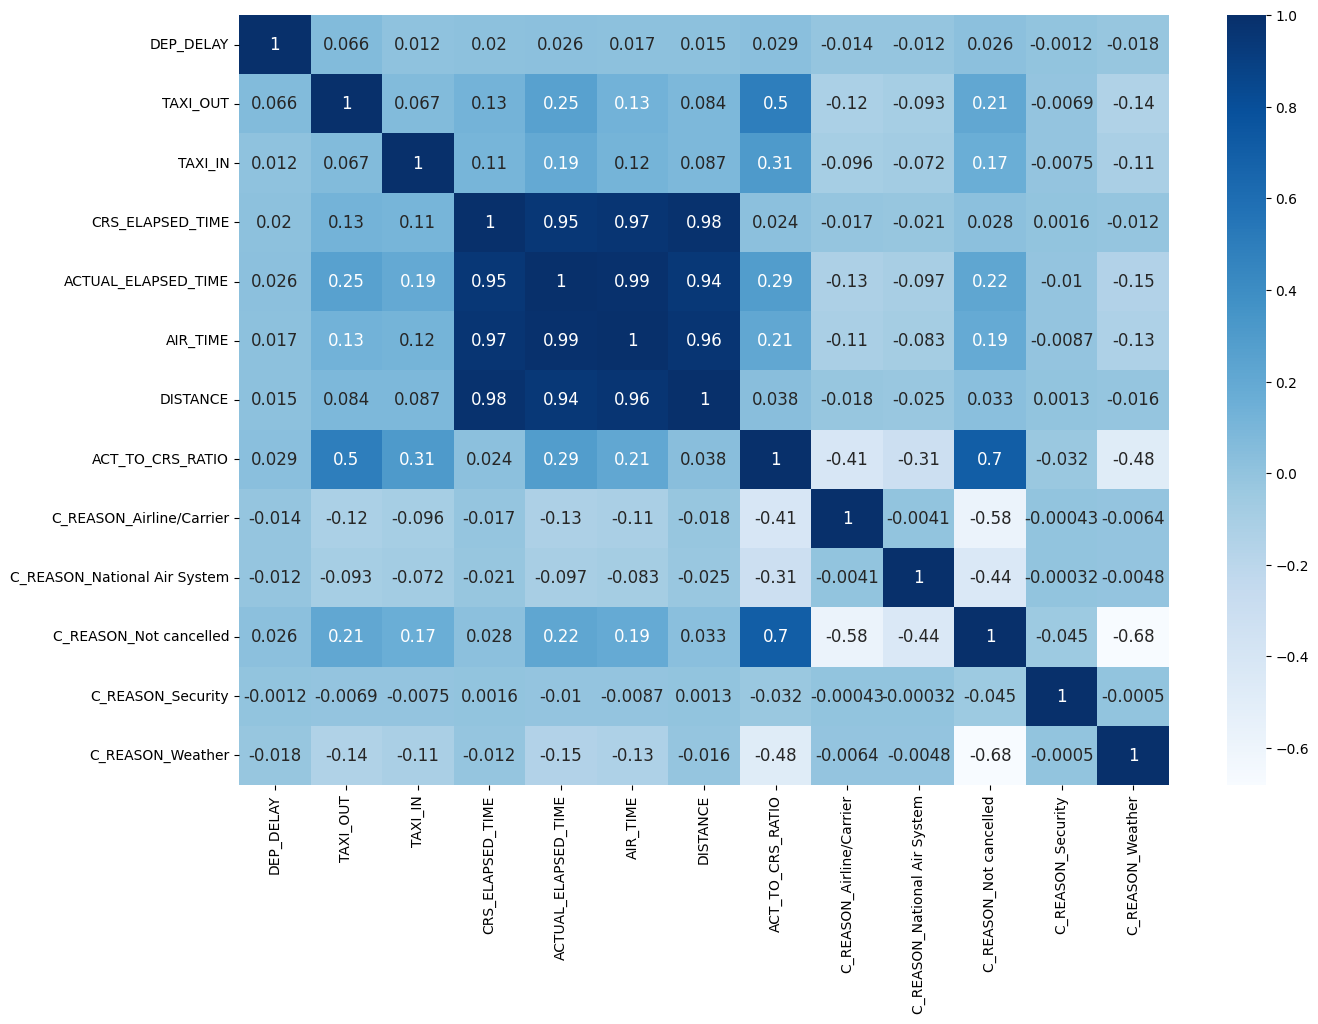

In [16]:
# Visualizzazione della heatmap per il sottoinsieme rimanente, con una dimensione personalizzata della figura
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df.drop(['FLIGHT_STATUS'], axis=1).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})  # Mostra la heatmap con annotazioni
plt.show()


In [17]:
df = df.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'C_REASON_Not cancelled'], axis=1)

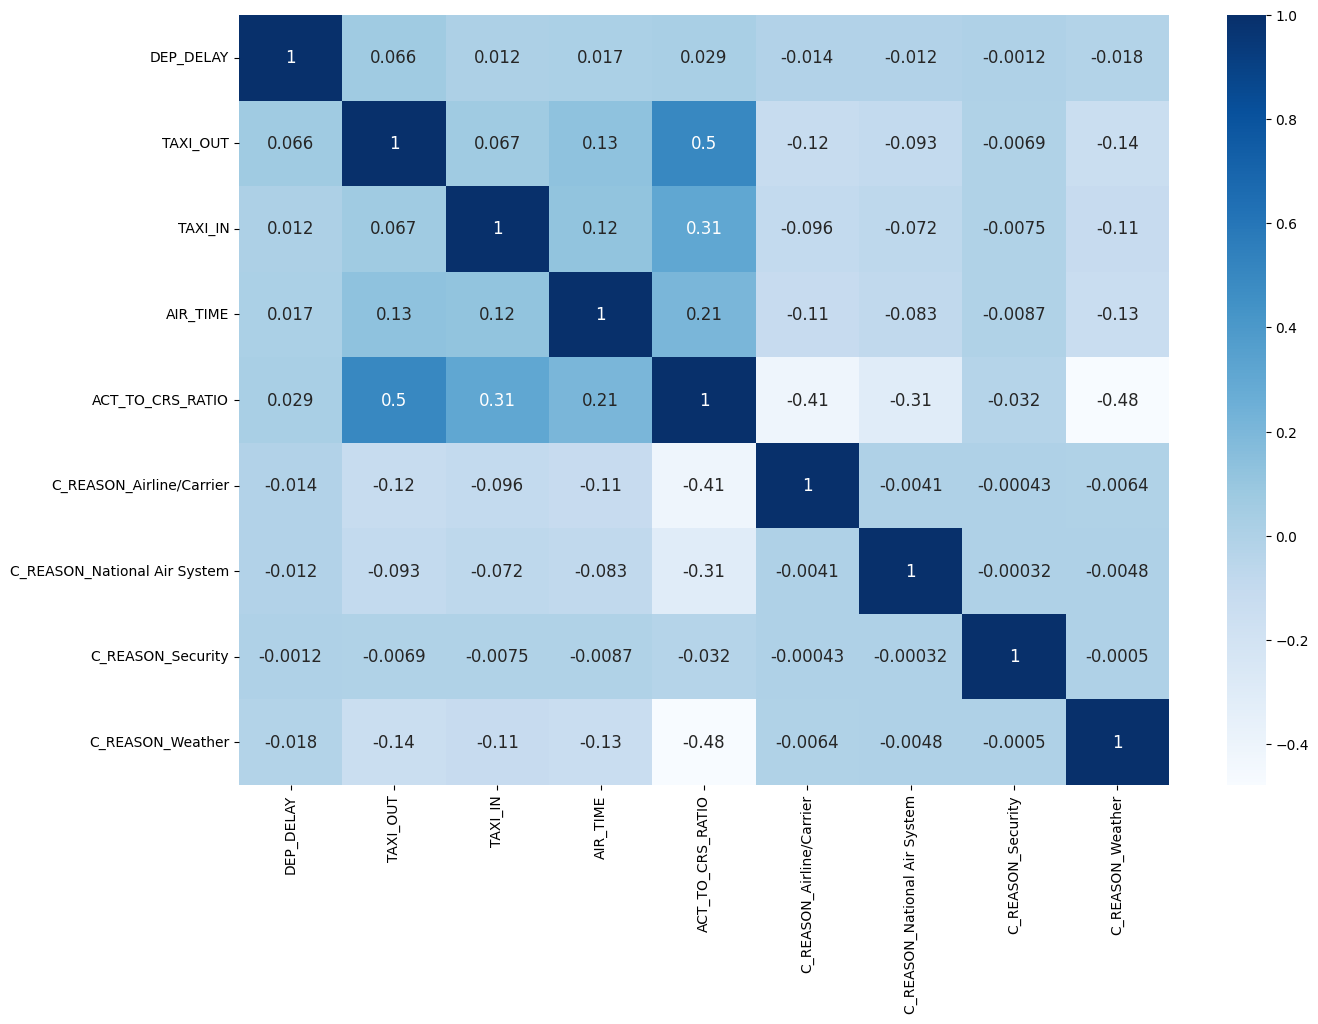

In [18]:
# Visualizzazione della heatmap per il sottoinsieme rimanente, con una dimensione personalizzata della figura
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df.drop(['FLIGHT_STATUS'], axis=1).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})  # Mostra la heatmap con annotazioni
plt.show()


# Classificazione

In [19]:
y = df['FLIGHT_STATUS']
x = df.drop(columns=['FLIGHT_STATUS'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 9)
(23855, 9)
(95416,)
(23855,)


## Bilanciamento

In [20]:
sample = 1500

# Crea una strategia di undersampling personalizzata
undersampler = RandomUnderSampler(
    sampling_strategy={0: sample, 1: sample, 2: sample, 3: sample, 4: sample, 
                    6: sample,
                    5: y_train[y_train == 5].shape[0]}, 
    random_state=42
)

# Applica l'undersampling al set di addestramento
x_train, y_train = undersampler.fit_resample(x_train, y_train)

# Controlla la distribuzione delle classi dopo l'undersampling
print(y_train.value_counts())


FLIGHT_STATUS
0    1500
1    1500
2    1500
3    1500
4    1500
6    1500
5     239
Name: count, dtype: int64


In [21]:
# Definisci la strategia di oversampling personalizzata per la classe 5
sampling_strategy = {5: 500}  # Crea 1000 esempi sintetici per la classe 5

# Applica SMOTE con la strategia di oversampling per la classe 5
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

# Visualizza la distribuzione delle classi dopo l'oversampling
print("\nDistribuzione delle classi dopo SMOTE:")
print(pd.Series(y_train).value_counts())

# Verifica la forma dei dati bilanciati
print("\nShape dei dati bilanciati (SMOTE):")
print(x_train.shape, y_train.shape)



Distribuzione delle classi dopo SMOTE:
FLIGHT_STATUS
0    1500
1    1500
2    1500
3    1500
4    1500
6    1500
5     500
Name: count, dtype: int64

Shape dei dati bilanciati (SMOTE):
(9500, 9) (9500,)


## Training

In [50]:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    GradientBoostingClassifier(random_state= rs),
    AdaBoostClassifier(n_estimators=20, random_state= rs),
    LinearDiscriminantAnalysis(),
    SVC(probability=True)
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame(y_test.copy())

kfold = StratifiedKFold(n_splits = 5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [51]:
# Calculate class weights: assign triple weight to class 5
class_weights = {i: 1 for i in range(len(y_train.unique()))}  # Default weight of 1 for all classes
class_weights[5] = 3  # Assign triple the weight to class 5

# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)

    # Apply class weights during training if the classifier supports it
    if hasattr(clf, 'class_weight'):
        clf.set_params(class_weight=class_weights)  # Set custom class weights

    # Fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred.tolist()

    # Accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring="accuracy", cv=kfold))
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2)  # Need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name}')

    # Confusion matrix, classification report, ROC curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

# Calculate cross-validation results
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 0.6 	 ---> LogisticRegression
Accuracy: 0.92 	 ---> DecisionTreeClassifier
Accuracy: 0.92 	 ---> RandomForestClassifier
Accuracy: 0.92 	 ---> GradientBoostingClassifier


c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

Accuracy: 0.58 	 ---> AdaBoostClassifier


c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.64 	 ---> LinearDiscriminantAnalysis
Accuracy: 0.73 	 ---> SVC


C:\Users\dswal\AppData\Local\Temp\ipykernel_16388\468612739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


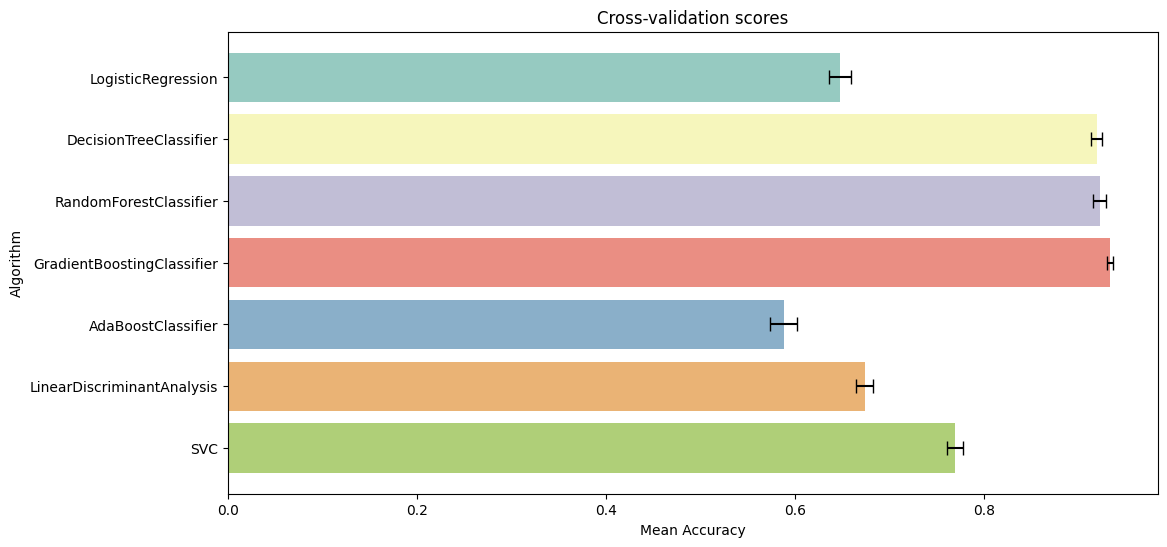

In [24]:
# Ensure consistency
cv_res = pd.DataFrame({"CrossValMeans": cv_acc, "CrossValerrors": cv_std, "Algorithm": clf_name})

# Plot
plt.figure(figsize=(12, 6))

# Barplot senza barre di errore
sns.barplot(
    x="CrossValMeans", y="Algorithm", data=cv_res,
    palette="Set3", orient="h"
)

# Aggiungi barre di errore manualmente
for index, row in cv_res.iterrows():
    plt.errorbar(
        x=row["CrossValMeans"], y=index, xerr=row["CrossValerrors"], fmt='none', c='black', capsize=5
    )

plt.xlabel("Mean Accuracy")
plt.title("Cross-validation scores")
plt.show()

In [25]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
cv_res.head()

,CrossValMeans,CrossValerrors,Algorithm
0,0.648105,0.012028,LogisticRegression
1,0.919579,0.005874,DecisionTreeClassifier
2,0.922842,0.006931,RandomForestClassifier
3,0.934105,0.003130,GradientBoostingClassifier
4,0.588211,0.014141,AdaBoostClassifier


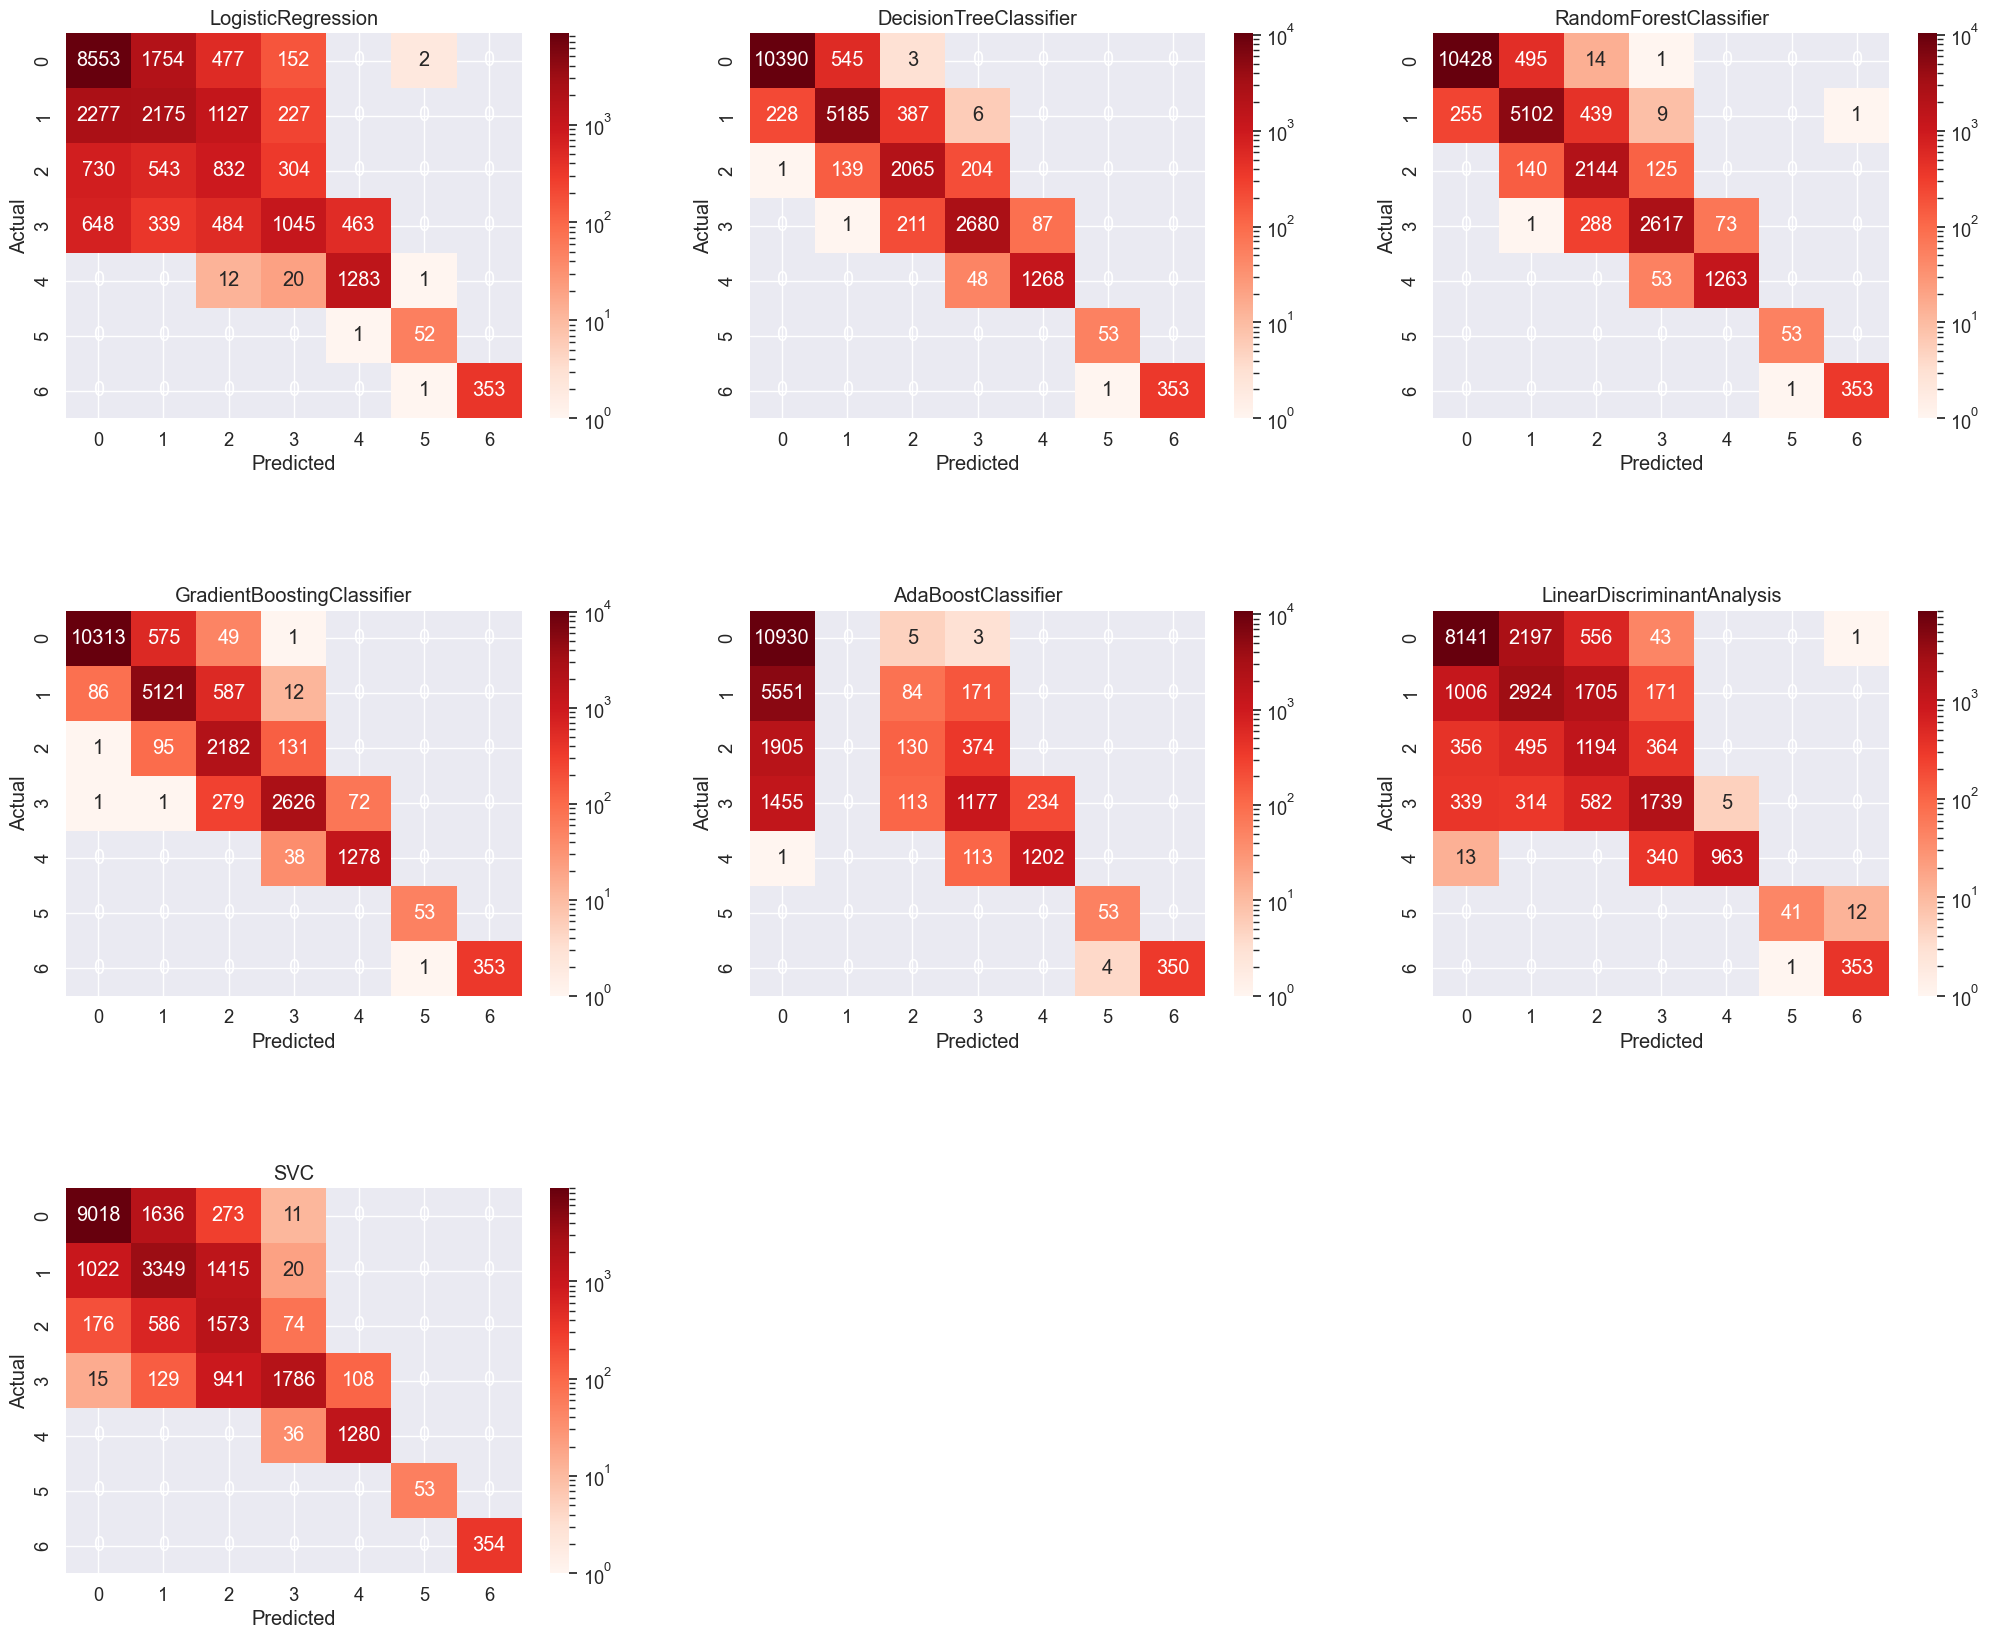

In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,20))
sns.set(font_scale=1.2)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1)  # Adjust this according to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d", cmap="Reds", 
                norm=LogNorm(vmin=1, vmax=cnfm[i].max()))  # Emphasize lower values
    plt.subplots_adjust(hspace=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])


In [27]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     10938
           1       0.45      0.37      0.41      5806
           2       0.28      0.35      0.31      2409
           3       0.60      0.35      0.44      2979
           4       0.73      0.97      0.84      1316
           5       0.93      0.98      0.95        53
           6       1.00      1.00      1.00       354

    accuracy                           0.60     23855
   macro avg       0.67      0.69      0.67     23855
weighted avg       0.59      0.60      0.59     23855

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10938
           1       0.88      0.89      0.89      5806
           2       0.77      0.86      0.81      2409
           3       0.91      0.90      0.91      2979
           4       0.94      0.96      0.95 

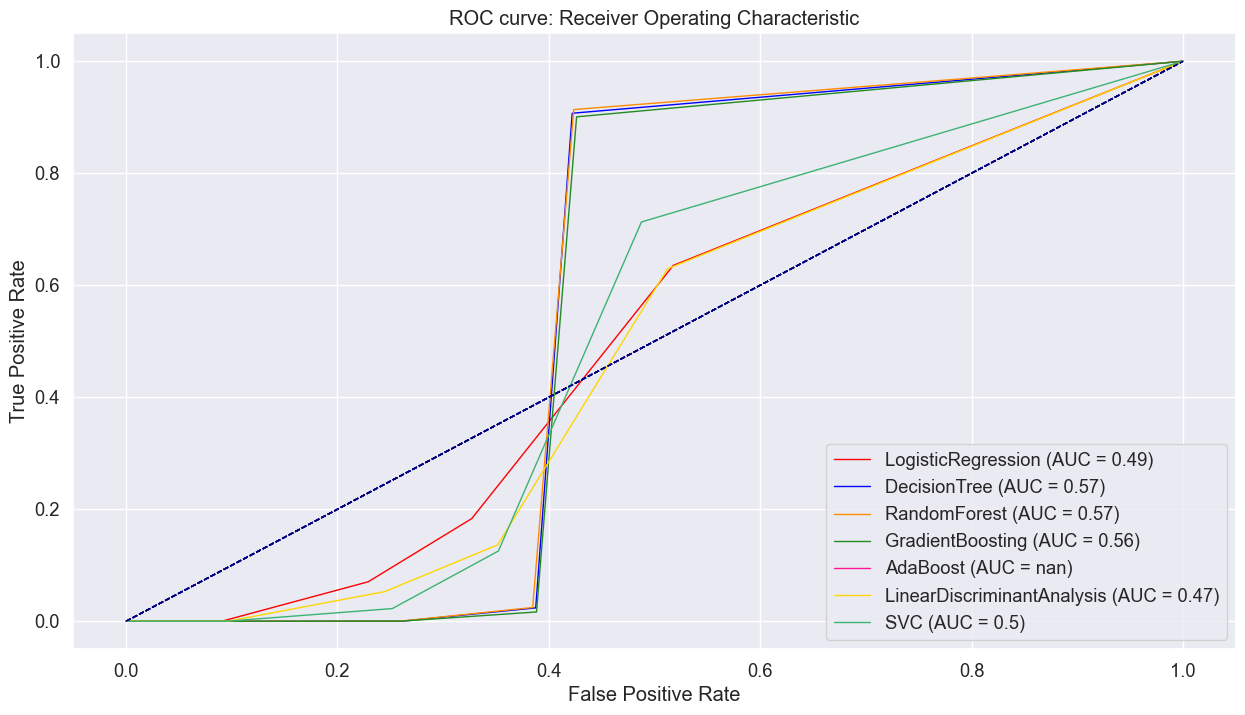

In [28]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'darkorange', 'forestgreen', 'deeppink', 'gold', 'mediumseagreen', 'gray', 'brown', 'deepskyblue']  # Improved color selection
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")


Text(0.5, 1.0, 'Correlation between models')

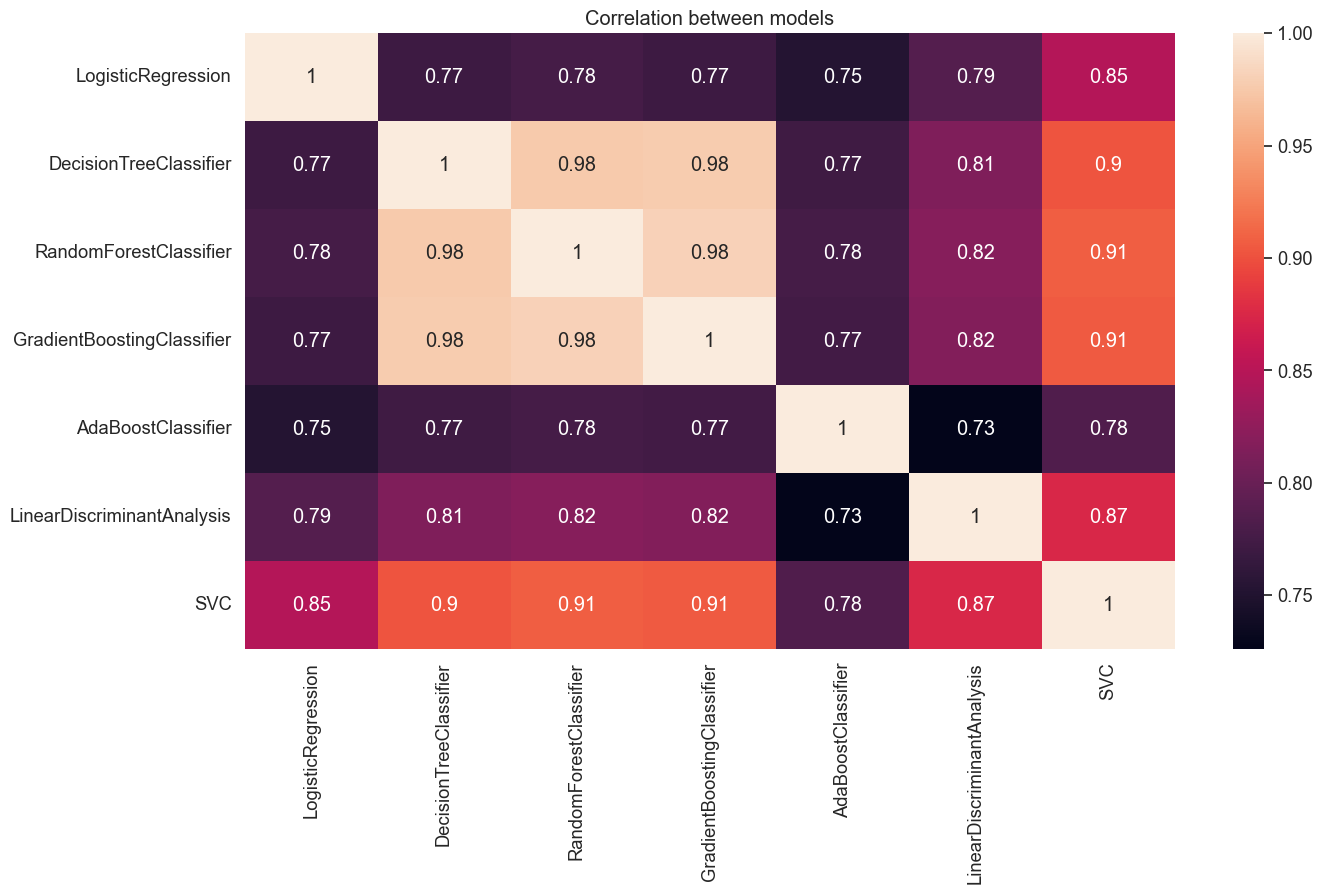

In [52]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop('FLIGHT_STATUS', axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [ ]:
# Parametri per AdaBoostClassifier
ADA_param = {
    "base_estimator": [DecisionTreeClassifier(max_depth=d) for d in [2, 3, 8]],  # Definisci un classificatore base
    "n_estimators": [50, 100, 300],
    "learning_rate": [0.01, 0.1, 1]
}

# Parametri per LinearDiscriminantAnalysis
LDA_param = {
    "solver": ["svd", "lsqr", "eigen"],  # Metodi di risoluzione
    "shrinkage": [None, "auto", 0.1, 0.5]  # Shrinkage per lsqr/eigen
}

# Creazione dei modelli
ADAgs = GridSearchCV(
    AdaBoostClassifier(), param_grid=ADA_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1
)
LDAgs = GridSearchCV(
    LinearDiscriminantAnalysis(), param_grid=LDA_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1
)

# Aggiunta dei modelli alla lista
models = [ADAgs, LDAgs]

gs_model = []
score = []

# Ciclo per addestrare e registrare i risultati
for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


AttributeError: 'NoneType' object has no attribute 'set_params'

In [30]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.92 0.934
score with GridSearchCV:  0.874 0.947


# Model Ensamble

In [55]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

0.9219031649549361


# Testing

In [77]:
# Load the test data
flights_test = pd.read_csv("dataset/test_flights.csv")

flights_test = ETL(flights_test)

# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 
    'ACT_TO_CRS_RATIO', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
    'AIR_TIME', 'DISTANCE'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
flights_test[standard_features] = min_max_scaler.fit_transform(flights_test[standard_features])

drop_features = [
    'CRS_DEP_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_DEP_TIME', 'ARR_DELAY', 
    'CANCELLED', 'DIVERTED', 'FL_YEAR', 

    'DEP_TIME', 'ARR_TIME','WHEELS_OFF', 'WHEELS_ON',
    'ORIGIN', 'DEST', 'OP_CARRIER',
    'FL_MON',	'FL_DAY',	'FL_DOW'
]

flights_test = flights_test.drop(columns=drop_features, errors='ignore')

flights_test = flights_test.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Create dummies - for better model outcomes
flights_test = pd.get_dummies(flights_test)

# Aggiungi la colonna 'C_REASON_Security' nella penultima posizione
flights_test.insert(len(flights_test.columns)-1, 'C_REASON_Security', 0)

# Replace NaNs with a placeholder category
flights_test.fillna(False, inplace=True)

flights_test = flights_test.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'C_REASON_Not cancelled'], axis=1)


In [78]:
#train the model on the whole dataset and produce results:
flights_status_pred = pd.Series(best_model.predict(flights_test), name='FLIGHT STATUS')

In [79]:
flights_status_pred.value_counts()

FLIGHT STATUS
3    46685
2     4897
1     3731
4     1929
6      936
0      314
5      165
Name: count, dtype: int64

# Yellowbrick

In [80]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

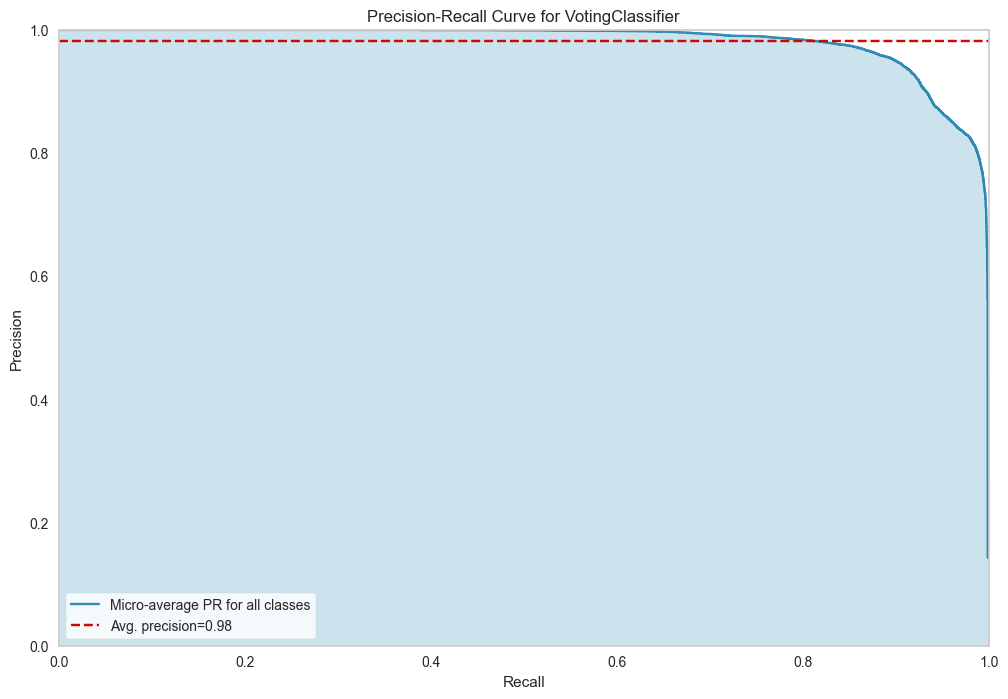

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [81]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

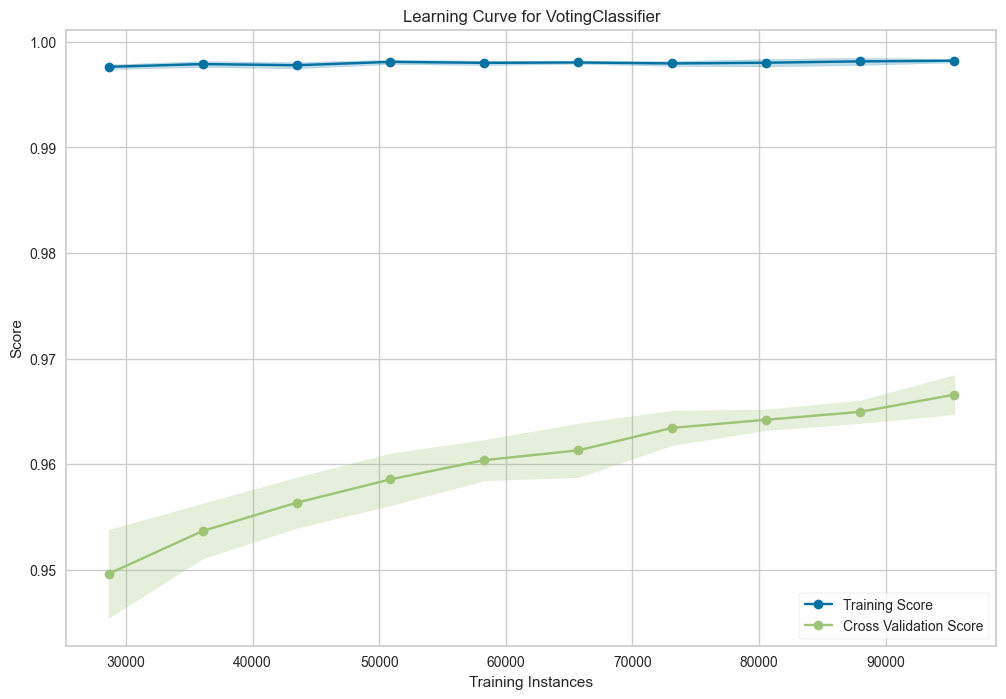

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [82]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure